In [2]:
# 路透社数据集

from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


2113536/2110848 [==============================] - 3s 1us/step

训练样本和测试样本

In [6]:
len(train_data)

8982

In [7]:
len(test_data)


2246

In [8]:
# 每一个样本都是一个整数列表（单词索引）
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [9]:
# 样本对应的标签是一个0~45之间的整数，即是话题索引编号
train_labels[10]

3

In [14]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    """
    数据向量化
    :param sequences:
    :param dimension:
    :return:
    """
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 将训练数据、测试数据向量化
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [15]:
def to_one_hot(labels, dimension=46):
    """
    标签的one-hot编码就是将每个标签表示成全零向量，只有标签索引对应的元素为1
    :param labels:
    :param dimension:
    :return:
    """
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 将训练标签、测试标签向量化
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [11]:
# keras中内置了上述操作
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


模型定义

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
# 最后一层是一个大小为46的Dense层，网络会输出一个46维的向量
model.add(layers.Dense(46, activation='softmax'))

编译模型

In [17]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

验证你的方法

In [18]:
# 在训练数据集中预留出1000个样本作为验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

训练模型

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 0s 21ms/step - loss: 2.5465 - accuracy: 0.5229 - val_loss: 1.6922 - val_accuracy: 0.6600
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 1.3731 - accuracy: 0.7157 - val_loss: 1.3030 - val_accuracy: 0.7170
Epoch 3/20
16/16 [==============================] - 0s 13ms/step - loss: 1.0236 - accuracy: 0.7776 - val_loss: 1.1384 - val_accuracy: 0.7460

绘制损失曲线和精度曲线

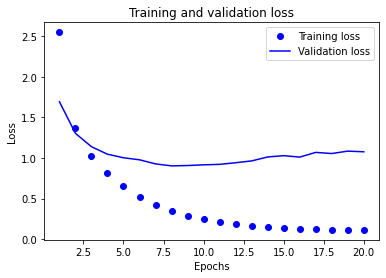

In [20]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


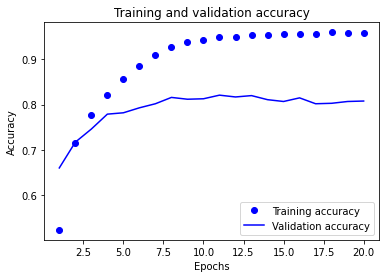

In [21]:
# 绘制训练精度和验证精度

# 清空图像
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

网络在训练9轮后开始过拟合，从头开始训练一个新的网络, 共9个轮次，再评估

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 0s 19ms/step - loss: 2.5369 - accuracy: 0.5336 - val_loss: 1.6795 - val_accuracy: 0.6580
Epoch 2/9
16/16 [==============================] - 0s 13ms/step - loss: 1.3902 - accuracy: 0.7164 - val_loss: 1.2954 - val_accuracy: 0.7120
Epoch 3/9
16/16 [==============================] - 0s 15ms/step - loss: 1.0477 - accuracy: 0.7711 - val_loss: 1.1265 - val_accuracy: 0.7580

In [23]:
results

[1.0388212203979492, 0.7813891172409058]

In [24]:
import copy

# 完全随机的精度约为19%，效果还不错
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hists_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hists_array)) / len(test_labels)


0.1834372217275156

在新数据上生成预测结果

In [25]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [26]:
np.sum(predictions[0])

1.0000001

In [27]:
# 最大的元素就是预测类别，即概率最大的类别
np.argmax(predictions[0])

3

测试 中间层维度足够大的重要性

In [31]:
model = models.Sequential()
# model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
# # 中间层的维度修改为4，大量信息压缩到维度很小的中间空间
# model.add(layers.Dense(4, activation='relu'))
# model.add(layers.Dense(46, activation='softmax'))

# 使用更少、或者更多的隐藏单元
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
# 中间层的维度修改为4，大量信息压缩到维度很小的中间空间
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)
results

Epoch 1/9
16/16 [==============================] - 0s 14ms/step - loss: 3.3123 - accuracy: 0.4327 - val_loss: 2.5908 - val_accuracy: 0.6610
Epoch 2/9
16/16 [==============================] - 0s 8ms/step - loss: 2.1005 - accuracy: 0.6824 - val_loss: 1.7562 - val_accuracy: 0.6720
Epoch 3/9
16/16 [==============================] - 0s 9ms/step - loss: 1.4909 - accuracy: 0.7147 - val_loss: 1.4216 - val_accuracy: 0.6980

[1.069076657295227, 0.7653606534004211]